In [245]:
include("../lna.jl")
using DifferentialEquations, StatsBase, Plots, Distributions, LaTeXStrings, DataFrames, CSV

# Setup

In [246]:
function reaction(n)
    "
    ρ_m$(n), 0 --> M$(n)
    δ_m$(n), M$(n) --> 0
    σ_b$(n), M$(n) + R --> MR$(n)
    δ_u$(n), MR$(n) --> M$(n) + R
    ρ_p$(n), MR$(n) --> M$(n) + P$(n) + R
    δ_mr$(n), MR$(n) --> 0
    δ_p$(n), P$(n) --> 0
    "
end

function endstring(n)
    cumulative_string = "end ρ_r δ_r "
    for i in 1:n
        cumulative_string = string(cumulative_string, "ρ_m$(i) δ_m$(i) σ_b$(i) δ_u$(i) ρ_p$(i) δ_mr$(i) δ_p$(i) ")
    end
    cumulative_string
end

function generate_rn(n)
    rnstring = "rn = @reaction_network begin
        ρ_r, 0 --> R
        δ_r, R --> 0
    "
    for i in 1:n
        rnstring = string(rnstring, reaction(i))
    end
    rnstring = string(rnstring, endstring(n))
    rnexpression = Base.Meta.parse(rnstring)
    eval(rnexpression)
end

function generate_propensities(n)
    rand(Float64, (6*n+2))
end

function relative_error(true_val, approx_val)
    map(abs, 1 .- approx_val./true_val)
end

# Valid always
function FF_single_gene_ribosome(props)
    k1 = props[3]
    k2 = props[4]
    k3 = props[5] - props[6] + props[7] # What should this really be?
    k6 = props[2]
    k7 = props[1]
    return 1 + k3*k7/(k6*(k2+k6))+k1*k3/(2*k2*k6)
end

# Valid if k2>>k6
function FF_single_gene_ribosome_approx(props)
    k1 = props[3]
    k2 = props[4]
    k3 = props[5]/props[6] + props[7]/ props[8] # What should this really be?
    k6 = props[2]
    k7 = props[1]
    return 1 + k3*k7/(k6*k2)+k1*k3/(2*k2*k6)
end

function FF_single_gene_ribosome_sim(props, p)
    k1 = props[3]
    k2 = props[4]
    k6 = props[2]
    k7 = props[1]
    k3 = p*k6*k2*k6/(k1*k7)
    return 1 + k3*k7/(k6*(k2+k6))+k1*k3/(2*k2*k6)
end

# Valid if k2>>k6
function FF_single_gene_ribosome_approx_sim(props, p)
    k1 = props[3]
    k2 = props[4]
    k6 = props[2]
    k7 = props[1]
    k3 = p*k6*k2*k6/(k1*k7)
    return 1 + k3*k7/(k6*k2)+k1*k3/(2*k2*k6)
end


FF_single_gene_ribosome_approx_sim (generic function with 1 method)

# Verifying the LNA solution

In [247]:
N = 10

rn = generate_rn(N)

ps = [50., .1]
    
for i in 1:N
    ps = vcat(ps, [1.5, .1, .2, .1, .5, .1, .1])
end

prob = LNAProblem(rn, zeros(Int, 3*N+3), ps)

sol = solve(prob)

lnameans = mean(sol)
lnacovs = StatsBase.cov(sol)

initial_values = map(Int64, map(ceil, lnameans))

prob = DiscreteProblem(rn, initial_values, (0, 1000000.),  ps)
jump_prob = JumpProblem(rn, prob, Direct(), save_positions=(false, false))

sol = solve(jump_prob, SSAStepper(), saveat=1.0)

protein_counts = map(x -> x[4], sol.u)

1000001-element Vector{Int64}:
 75
 73
 73
 73
 79
 77
 72
 75
 76
 76
 75
 76
 70
  ⋮
 87
 86
 81
 83
 83
 76
 80
 81
 85
 82
 86
 79

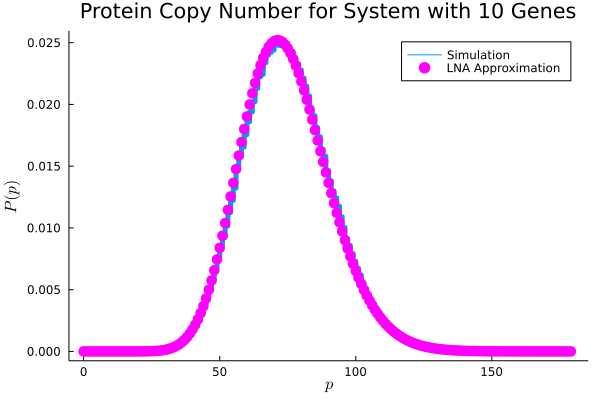

In [248]:
histogram(protein_counts, nbins=maximum(protein_counts), norm=true, label="Stochastic Simulation Algorithm")

prot_mean = lnameans[4]
prot_var = lnacovs[4,4]

p = prot_mean/prot_var
r = prot_var*p^2/(1-p)

nb = NegativeBinomial(r,p)
xs = [0:1:maximum(protein_counts)]
ys = Distributions.pdf(nb, xs)

histogram(
    protein_counts, 
    nbins=maximum(protein_counts), 
    norm=true, 
    label="Simulation",
    linewidth=5,
    color=RGBA(0/255, 159/255, 227/255, 254/255)
)

scatter!(
    xs,
    ys, 
    label="LNA Approximation", 
    title = "Protein Copy Number for System with $N Genes", 
    xlabel=L"p", 
    ylabel=L"P(p)",
    markersize=6,
    markercolor=RGBA(255/255, 0/255, 255/255, 255/255),
    markershape=:circle,
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    grid=false
)

In [249]:
savefig("../../data/figures-for-paper/protein_copy_number_$(N)_genes.svg")

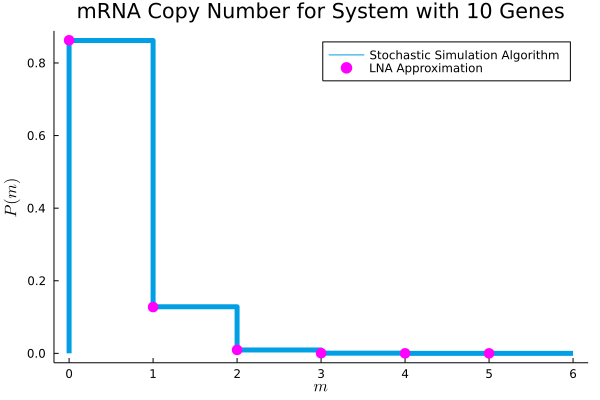

In [250]:
mrna_counts = map(x -> x[2], sol.u)
histogram(mrna_counts, 
    nbins=maximum(mrna_counts), 
    norm=true, 
    label="Stochastic Simulation Algorithm",
    linewidth=5,
    color=RGBA(0/255, 159/255, 227/255, 254/255)
)

m_mean = lnameans[2]
m_var = lnacovs[2,2]

p = m_mean/m_var
r = m_var*p^2/(1-p)

nb = NegativeBinomial(r,p)
xs = [0:1:maximum(mrna_counts)]
ys = Distributions.pdf(nb, xs)
scatter!(
    xs,
    ys,
    label="LNA Approximation", 
    title = "mRNA Copy Number for System with $(N) Genes",
    xlabel=L"m",
    ylabel=L"P(m)",
    markersize=6,
    markercolor=RGBA(255/255, 0/255, 255/255, 255/255),
    markershape=:circle,
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    grid=false
)

In [251]:
savefig("../../data/figures-for-paper/mrna_copy_number_$(N)_genes.svg")

# Comparison of Full and Reduced Models

In [253]:
xs = 1:10:100
ffs_full = zeros(length(xs))
ffs_red = zeros(length(xs))
ffs_red_approx = zeros(length(xs))

for i in 1:length(xs)
    N = xs[i]
    rn = generate_rn(N)

    ps = [50., .1]

    for j in 1:N
        ps = vcat(ps, [1.5, .1, .2, .1, .5, .1, .1])
    end

    prob = LNAProblem(rn, zeros(Int, 3*N+3), ps)

    sol = solve(prob)

    lnameans = mean(sol)
    lnacovs = StatsBase.cov(sol)

    ffs_full[i] = lnacovs[4,4]/lnameans[4]
    ffs_red[i] = FF_single_gene_ribosome_sim(ps, lnameans[4])
    ffs_red_approx[i] = FF_single_gene_ribosome_approx_sim(ps, lnameans[4])
end

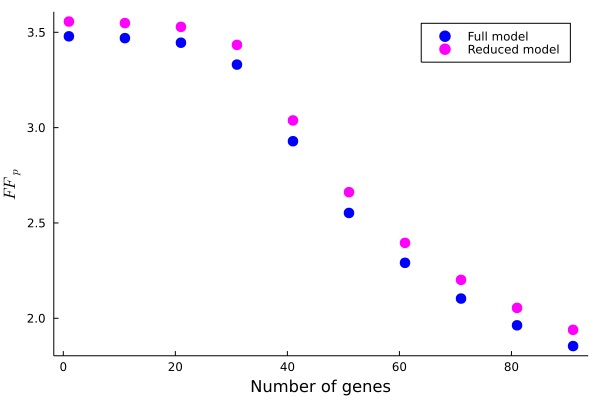

In [254]:
scatter(
    xs,
    ffs_full,
    label="Full model",
    markersize=6,
    markercolor=RGBA(0/255, 0/255, 255/255, 255/255),
    markershape=:circle,
    markerstrokecolor=RGBA(0/255, 0/255, 255/255, 255/255),
)

scatter!(
    xs,
    ffs_red,
    label="Reduced model",
    xlabel="Number of genes",
    ylabel=L"FF_{p}",
    markersize=6,
    markercolor=RGBA(255/255, 0/255, 255/255, 255/255),
    markershape=:circle,
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    grid=false)

In [255]:
savefig("../../data/figures-for-paper/full_model_verses_reduced_model_$(N)_genes.svg")

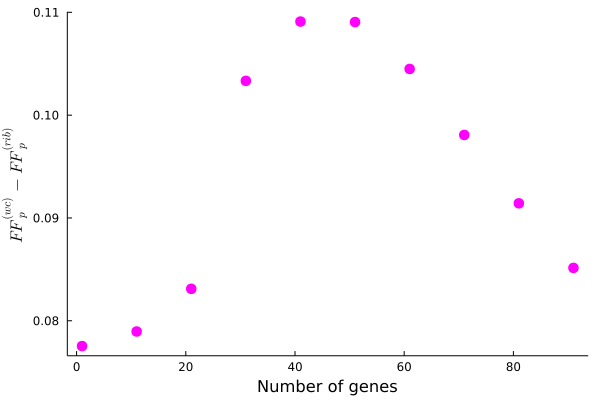

In [256]:
scatter(
    xs,
    ffs_red-ffs_full,
    ylabel=L"FF_p^{(wc)} - FF_p^{(rib)}",
    xlabel="Number of genes",
    markersize=6,
    markercolor=RGBA(255/255, 0/255, 255/255, 255/255),
    markershape=:circle,
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    legend=false,
    grid=false
)

In [257]:
savefig("../../data/figures-for-paper/residuals_full_model_ribosome_model_$(N)_genes.svg")

# Choosing Realistic Parameters

In [258]:
# Load data from schwannhauser
exp_data = DataFrame(CSV.File("../../data/experimental_data_sanitised.csv"))
dropmissing!(exp_data)
names(exp_data)

7-element Vector{String}:
 "id"
 "pNumber"
 "mNumber"
 "alpha"
 "beta"
 "mHalfLife"
 "pHalfLife"

In [262]:
median(exp_data[!, :pNumber])

41913.32

In [263]:
mean(exp_data[!, :pNumber])

475168.0025453261

In [264]:
sort(exp_data, [:pNumber])[50, :]

,id,pNumber,mNumber,alpha,beta,mHalfLife,pHalfLife
,String,Float64,Float64,Float64,Float64,Float64,Float64
50,IPI00136246.1,343.98,17.43,2.0,1.57,8.54,39.97


In [ ]:
N = 10

rn = generate_rn(N)

ps = [50., .1]
    
for i in 1:N
    ps = vcat(
        ps, 
        [
            1.9, # mRNA creation
            log(2)/8.54, # mRNA degredation
            .01, # binding to polysome
            0.001, # unbinding from polysome
            5.0, # translation,
            .1, # monosome decay
            .1 # protein decay
        ]
    )
end


prob = LNAProblem(rn, zeros(Int, 3*N+3), ps)

sol = solve(prob)

lnameans = mean(sol)
lnacovs = StatsBase.cov(sol)

initial_values = map(Int64, map(ceil, lnameans))

prob = DiscreteProblem(rn, initial_values, (0, 10000000.),  ps)
jump_prob = JumpProblem(rn, prob, Direct(), save_positions=(false, false))

sol = solve(jump_prob, SSAStepper(), saveat=1.0)
mrna_counts = map(x -> x[2], sol.u)
monosome_counts = map(x -> x[3], sol.u)
protein_counts = map(x -> x[4], sol.u)
ribosome_counts = map(x -> x[1], sol.u)

print("
    mRNA counts: $(mean(mrna_counts + monosome_counts))\n
    unbound mRNA counts: $(mean(mrna_counts))\n
    protein counts: $(mean(protein_counts))\n
    ribosomes counts: $(mean(ribosome_counts))\n
    ")

In [199]:
mean(mrna_counts + monosome_counts)

21.220799977920002

In [200]:
mean(mrna_counts)

11.821409617859038

In [201]:
mean(protein_counts)

470.0442120955788

In [202]:
mean(ribosome_counts)

405.905749609425

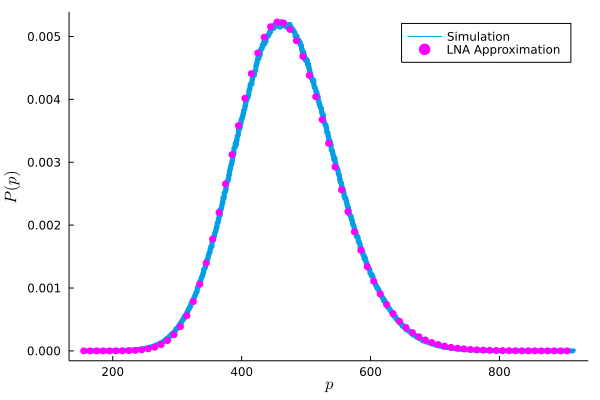

In [212]:
prot_mean = lnameans[4]
prot_var = lnacovs[4,4]

p = prot_mean/prot_var
r = prot_var*p^2/(1-p)

nb = NegativeBinomial(r,p)
step = 10
xs = [minimum(protein_counts):step:maximum(protein_counts)]
ys = Distributions.pdf(nb, xs)

histogram(
    protein_counts, 
    nbins=maximum(protein_counts), 
    norm=true, 
    label="Simulation",
    linewidth=5,
    color=RGBA(0/255, 159/255, 227/255, 254/255)
)

scatter!(
    xs,
    ys, 
    label="LNA Approximation", 
    xlabel=L"p", 
    ylabel=L"P(p)",
    color = RGBA(255/255, 0/255, 255/255, 255/255),
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    grid=false,
    markersize=4
)

In [213]:
savefig("../../data/figures-for-paper/protein_count_$(N)_genes_IPI00136246.svg")

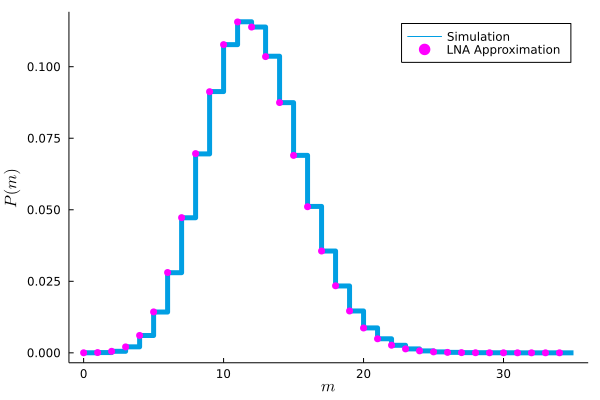

In [219]:
mrna_mean = lnameans[2]
mrna_var = lnacovs[2,2]

p = mrna_mean/mrna_var
r = mrna_var*p^2/(1-p)

nb = NegativeBinomial(r,p)
step = 1
xs = [minimum(mrna_counts):step:maximum(mrna_counts)]
ys = Distributions.pdf(nb, xs)


histogram(
    mrna_counts, 
    nbins=maximum(mrna_counts), 
    norm=true, 
    label="Simulation",
    linewidth=5,
    color=RGBA(0/255, 159/255, 227/255, 254/255)
)

scatter!(
    xs,
    ys, 
    label="LNA Approximation", 
    xlabel=L"m", 
    ylabel=L"P(m)",
    color = RGBA(255/255, 0/255, 255/255, 255/255),
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    grid=false,
    markersize=4
)

In [220]:
savefig("../../data/figures-for-paper/mrna_count_$(N)_genes_IPI00136246.svg")

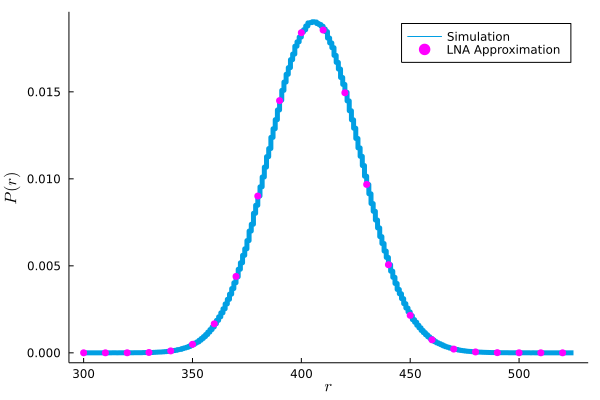

In [232]:
rib_counts = ribosome_counts
rib_mean = lnameans[1]
rib_var = lnacovs[1,1]

p = rib_mean/rib_var
r = rib_var*p^2/(1-p)

nb = NegativeBinomial(r,p)
step = 10
xs = [minimum(rib_counts):step:maximum(rib_counts)]
ys = Distributions.pdf(nb, xs)


histogram(
    rib_counts, 
    nbins=400, 
    norm=true, 
    label="Simulation",
    linewidth=5,
    color=RGBA(0/255, 159/255, 227/255, 254/255)
)

scatter!(
    xs,
    ys, 
    label="LNA Approximation", 
    xlabel=L"r", 
    ylabel=L"P(r)",
    color = RGBA(255/255, 0/255, 255/255, 255/255),
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    grid=false,
    markersize=4
)

In [233]:
savefig("../../data/figures-for-paper/rib_count_$(N)_genes_IPI00136246.svg")

# Comparing Differences for Large Number of Genes

The first idea here is to use the IPI00136246 gene and have N perturbed copies. The total number of ribosomes will need to be much larger than the number of proteins.

In [242]:
N = 10
xs = 1:10:100
ffs_full = zeros(length(xs))
ffs_red = zeros(length(xs))
ffs_red_approx = zeros(length(xs))

for i in 1:length(xs)
    N = xs[i]
    rn = generate_rn(N)

    
    ps = [50., .1]
    for i in 1:N
        ps = vcat(
            ps, 
            [
                1.9, # mRNA creation
                log(2)/8.54, # mRNA degredation
                .01, # binding to polysome
                0.001, # unbinding from polysome
                5.0, # translation,
                .1, # monosome decay
                .1 # protein decay
            ]
        )
    end


    prob = LNAProblem(rn, zeros(Int, 3*N+3), ps)

    sol = solve(prob)

    lnameans = mean(sol)
    lnacovs = StatsBase.cov(sol)
    

    ffs_full[i] = lnacovs[4,4]/lnameans[4]
    ffs_red[i] = FF_single_gene_ribosome_sim(ps, lnameans[4])
    ffs_red_approx[i] = FF_single_gene_ribosome_approx_sim(ps, lnameans[4])
end

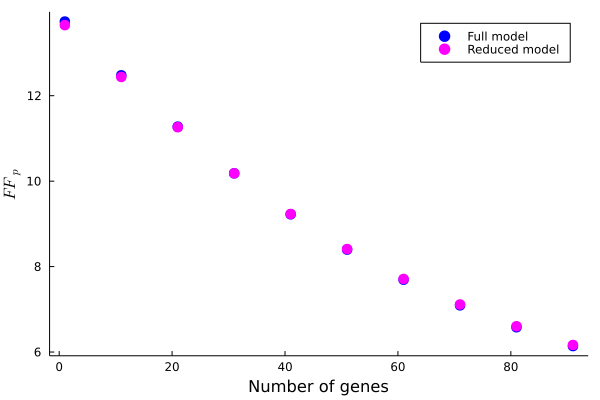

In [243]:
scatter(
    xs,
    ffs_full,
    label="Full model",
    markersize=6,
    markercolor=RGBA(0/255, 0/255, 255/255, 255/255),
    markershape=:circle,
    markerstrokecolor=RGBA(0/255, 0/255, 255/255, 255/255),
)

scatter!(
    xs,
    ffs_red,
    label="Reduced model",
    xlabel="Number of genes",
    ylabel=L"FF_{p}",
    markersize=6,
    markercolor=RGBA(255/255, 0/255, 255/255, 255/255),
    markershape=:circle,
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    grid=false
)

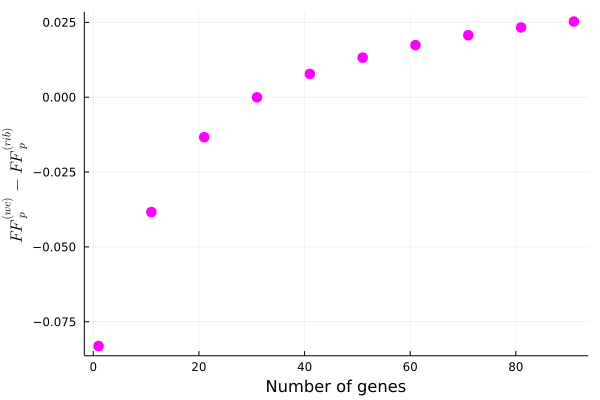

In [244]:
scatter(
    xs,
    ffs_red-ffs_full,
    ylabel=L"FF_p^{(wc)} - FF_p^{(rib)}",
    xlabel="Number of genes",
    markersize=6,
    markercolor=RGBA(255/255, 0/255, 255/255, 255/255),
    markershape=:circle,
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    legend=false,
    grid=false
)

This assumes that the rate parameters are "real" variables which are independent of the number of genes. In reality the single gene model should have different inferred parameters which produce the same measured quantities, ie the gene number and decay rate. Since the decay rate is measurable we can keep those variables the same and only have to infer the protein constants.